In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
# import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display 

# set some parameters:
# today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = "2015-11-01"
end_date ="2021-05-31"

start_end = [start_date, end_date]

unit_label = "p/100m"

unit_value = 100

fail_rate = 50

sns.set_style("whitegrid")

# colors for gradients
cmap2 = ck.cmap2

# colors for projects
this_palette = {"2020":"dodgerblue", "2018":"magenta"}
this_palettel = {"2020":"teal", "2018":"indigo"}

# get the data:
survey_data = pd.read_csv("resources/agg_results_with_land_use_2015.csv")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# there is a misspelling in survey data
survey_data.rename(columns={"% to agg":"% to ag"}, inplace=True)

# a common aggregation
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}

# reference columns
use_these_cols = ["survey year","loc_date" ,"% to buildings", "% to trans", "% to recreation", "% to ag", "% to woods","population","water_name_slug","streets km", "intersects", "groupname","code"]

# explanatory variables:
luse_exp = ["% to buildings", "% to recreation", "% to ag", "% to woods", "streets km", "intersects"]

# lakes that have samples in both years
these_lakes = ["zurichsee", "bielersee", "lac-leman", "neuenburgersee", "walensee", "thunersee"]

# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# index the code data
dfCodes.set_index("code", inplace=True)

dfCodes =  sut.shorten_the_value(["G178", "description", "metal bottle tops"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(slr-iqaasl)=
# More and less since 2018

he first national beach litter report was produced in 2018. The Swiss Litter Report (SLR) was a project initiated by Gabriele Kuhl  {cite}`stoppp` and supported by the World Wildlife Fund Switzerland {cite}`wwf`. The protocol was based on the Guide for monitoring marine litter {cite}`mlwguidance`, the project was managed by the WWF and the surveys were conducted by volunteers from both organizations. The project began in April 2017 and ended March 2018 the SLR covered much of the national territory except for the Ticino region. 

The SLR collected 1,052 samples from 112 locations. More than 150 trained volunteers from 81 municipalities collected and categorized 98,474 pieces of trash from the shores of 48 lakes and 67 rivers in Switzerland. {cite}`slr`

The most obvious question is: Was there more or less litter observed in 2020 than 2018? To answer the question the survey locations from each project were first compared based on the land use profile within 1500m of each survey location for each project. The survey results were limited to: 

1. Rivers and lakes with samples in both years 
2. Only objects that were identified in 2018 were considered

From this subset of data, the median survey total of all objects and the average survey total of the most common objects were compared to identify statistically significant changes in either direction from one project to the next. This test was conducted on two groups of the subset: 

1. Rivers and lakes combined with samples from both projects
2. Only the lakes with samples from both projects

## Scope of projects SLR - IQAASL

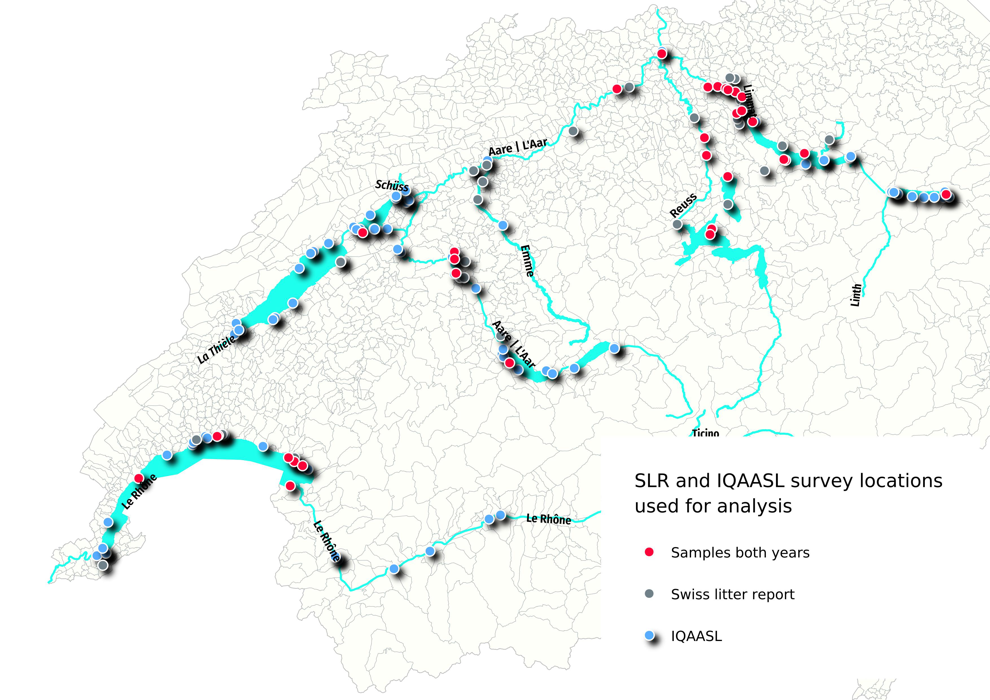

In [2]:
sut.display_image_ipython("resources/maps/slr_iqasl.jpeg", thumb=(1200, 700))

In [3]:
# make sure date is time stamp
survey_data["date"] = pd.to_datetime(survey_data["date"], format="%Y-%m-%d")

# get only the water features that were sampled in 2020
after_2020 = survey_data[survey_data["date"] >= "2020-01-01"].water_name_slug.unique()
a_data = survey_data[survey_data.water_name_slug.isin(after_2020)].copy()

# convert pcs-m to unit_value
a_data["pcs_m"] = (a_data.pcs_m * unit_value).astype("int")
a_data.rename(columns={"pcs_m":unit_label}, inplace=True)

# the date ranges of two projects
first_date_range = (a_data.date >= "2017-04-01")&(a_data.date <= "2018-03-31")
second_date_range = (a_data.date >= "2020-04-01")&(a_data.date <= "2021-03-31")

# a df for each set
slr_data = a_data[first_date_range].copy()
iqasl_data = a_data[second_date_range].copy()

# only use codes identified in the first project
these_codes = slr_data[slr_data.quantity > 0].code.unique()

# add a survey year column to each data set
iqasl_data["survey year"] = "2020"
slr_data["survey year"] = "2018"

# put the two sets of data back together
combined_data = pd.concat([iqasl_data, slr_data])
combined_data["length"] = (combined_data.quantity/combined_data[unit_label])*unit_value

# unique locations in both years
sdlocs = slr_data.location.unique()
iqs = iqasl_data.location.unique()

# locations common to both
both_years = list(set(sdlocs).intersection(iqs))

# locations specific to each year
just_2017 = [x for x in sdlocs if x not in iqs]
j_2020 = [x for x in iqs if x not in sdlocs]

# use only the codes identified in 2017, the protocol only called for certain MLW codes
df = combined_data[combined_data.code.isin(these_codes)].copy()

# scale the streets value
df["streets km"] = (df.streets/1000).round(1)

### Land use profile of survey locations

The land use profile is the measurable properties that are geolocated and can be extracted from the current versions of *Statistique Suisse de la superficie* {cite}`superficie` and *swissTlmRegio* {cite}`tlmregio`. The land use profile is an estimate of the type and amplitude of economic activity near the survey locations. The following values were calculated within a radius of 1500m of each survey location:

1. \% of surface area attributed to buildings
2. \% of surface area left to woods
3. \% of surface area attributed to outdoor activities
4. \% of surface area attributed to aggriculture
5. length in meters of all roadways 
6. number of river discharge intersections

As of June 22, 2021, the land use data for Walensee was not up to date. Walensse has been estimated by visually inspecting the relevant map layers and comparing land use rates to other locations that have a similar population. For details on how this is calculated and why it is important see The land use profile. [_The land use profile_](luseprofile).

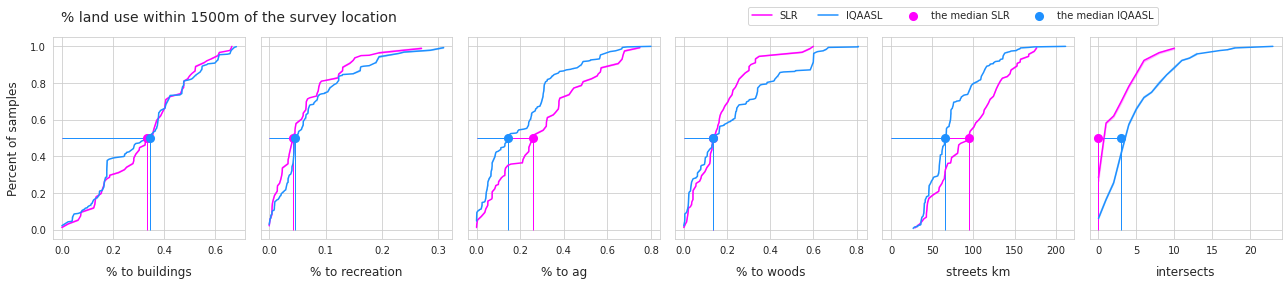

In [4]:
# !!walensee landuse is approximated by comparing the land use profile from similar locations!!
# the classification for that part of switzerland is incomplete for the current estimates
# the land use profile of wychely - brienzersee was used for walenstadt-wyss (more prairie, buildings less woods)
# the land use profile of grand-clos - lac-leman was used for other locations on walensee (more woods, less buildings, less praire and agg)
luse_wstdt = dfBeaches.loc["wycheley"][["population","% to buildings", "% to trans", "% to recreation", "% to agg", "% to woods"]]
estimate_luse = dfBeaches.loc["grand-clos"][["population","% to buildings", "% to trans", "% to recreation", "% to agg", "% to woods"]]

# seperate out the locations that aren"t walenstadt
wlsnsee_locs_not_wstdt = ["gasi-strand", "untertenzen", "mols-rocks", "seeflechsen", "seemuhlestrasse-strand", "muhlehorn-dorf", "murg-bad", "flibach-river-right-bank"]

for a_param in estimate_luse.index:
    df.loc[df.location.isin(wlsnsee_locs_not_wstdt), a_param] = estimate_luse[a_param]
    df.loc["walensee_walenstadt_wysse", a_param] = luse_wstdt[a_param]
    
dfdt = df.groupby(use_these_cols[:-2], as_index=False).agg(agg_pcs_quantity)

# chart the distribtuion of survey results with respect to the land use profile
fig, axs = plt.subplots(1, len(luse_exp), figsize=(len(luse_exp)*3,4), sharey="row")

data=dfdt[(dfdt["survey year"] == "2018")].groupby(use_these_cols[:-2], as_index=False).agg({"p/100m":"sum", "quantity":"sum"})
data2=dfdt[(dfdt["survey year"] == "2020")].groupby(use_these_cols[:-2], as_index=False).agg({"p/100m":"sum", "quantity":"sum"})

for i, n in enumerate(luse_exp):
    ax=axs[i]
    
    # land use data for each project
    the_data = ECDF(data[n].values)       
    the_data2 = ECDF(data2[n].values)
    
    # the median value    
    the_median = np.median(data[n].values)
    median_two = np.median(data2[n].values)    
    
    # plot the curves
    sns.lineplot(x= the_data.x, y=the_data.y, ax=ax, color=this_palette["2018"], label="SLR")
    sns.lineplot(x=the_data2.x, y=the_data2.y, ax=ax, color=this_palette["2020"], label="IQAASL")
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color=this_palette["2018"],s=50, linewidth=2, zorder=100, label="the median SLR")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color=this_palette["2018"], linewidth=1)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color=this_palette["2018"], linewidth=1)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([median_two], 0.5, color=this_palette["2020"],s=50, linewidth=2, zorder=100, label="the median IQAASL")
    ax.vlines(x=median_two, ymin=0, ymax=0.5, color=this_palette["2020"], linewidth=1)
    ax.hlines(xmax=median_two, xmin=0, y=0.5, color=this_palette["2020"], linewidth=1)
    if i == 0:
        ax.get_legend().remove()
        ax.set_ylabel("Percent of samples", **ck.xlab_k)
    else:
        ax.get_legend().remove()
    ax.set_xlabel(n, **ck.xlab_k)
    
handles, labels=ax.get_legend_handles_labels()

plt.subplots_adjust(top=.9)
plt.suptitle("% land use within 1500m of the survey location", ha="left", x=0.05, y=.97, fontsize=14)    
plt.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(.9,1), loc="upper right", ncol=4)

plt.show()

*__Above__ Distribution of number of surveys with respect to land use profile SLR - IQAASL* 

The sample locations in the SLR had a greater percent of land attributed to agriculture and a denser road network compared to locations in IQAASL. The percent of land attributed to woods diverges after the median at which point the locations in IQAASL had a greater percentage of land attributed to woods compared to SLR. 

The population (not shown) is taken from statpop 2018  {cite}`statpop`.     The smallest population was 442 and the largest was 415,357. At least 50% of the samples came from municipalities with a population of 13,000 or less. 

If percent of land use attributed to agriculture is a sign of urbanization, then the survey areas in 2020 were slightly more urban than 2018. 

## Results lakes and rivers

Considering only lakes and rivers that have samples in both years, there were more samples and trash collected from fewer locations in 2018 than 2020. However, on a pieces per meter basis the median was greater in 2020. 

### Distribution of results 2018 and 2020

*__Top Left:__ survey totals by date. __Top right:__ median monthly survey total. __bottom Left:__ number of samples with respect to the survey total. __bottom right:__ empirical cumulative distribution of survey totals.*

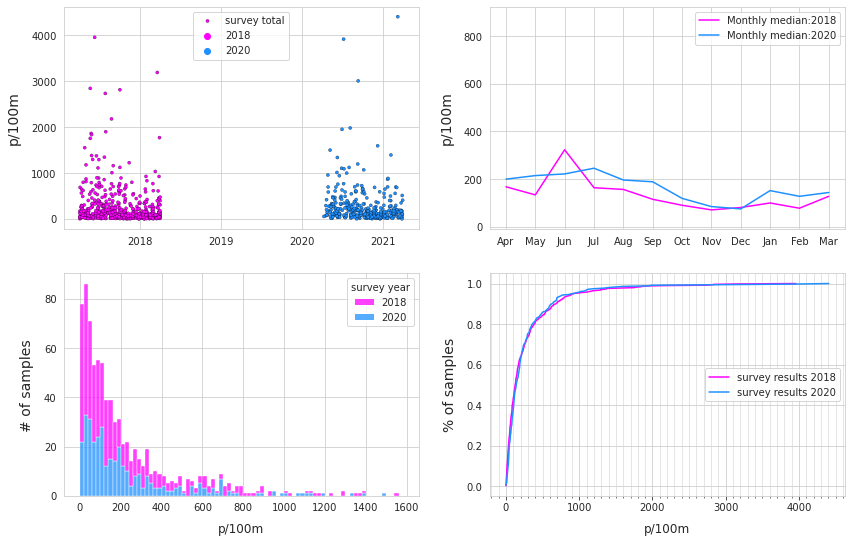

In [5]:
# group by survey and sum all the objects for each survey AKA: survey total
data=df.groupby(["survey year","water_name_slug","loc_date", "location", "date"], as_index=False)[unit_label].sum()
data["lakes"] = data.water_name_slug.isin(these_lakes)

# get the ecdf for both projects
ecdf_2017 = ECDF(data[data["survey year"] == "2018"][unit_label].values)
ecdf_2020 = ECDF(data[data["survey year"] == "2020"][unit_label].values)

# get the ecddf for the condition lakes in both years
l2017 = data[(data.water_name_slug.isin(these_lakes))&(data["survey year"] == "2018")].copy()
l2020 = data[(data.water_name_slug.isin(these_lakes))&(data["survey year"] == "2020")].copy()

ecdf_2017l = ECDF(l2017[unit_label].values)
ecdf_2020l = ECDF(l2020[unit_label].values)

# convenience func and dict to display table values
change_names = {"count":"# samples", "mean":F"average {unit_label}", "std":"standard deviation", "min":F"min {unit_label}",  "25%":"25%",  "50%":"50%", "75%":"75%", "max":F"max {unit_label}", "min":"min p/100", "total objects":"total objects", "# locations":"# locations", "survey year":"survey year"}

# group by survey year and use pd.describe to get basic stats
som_1720 = data.groupby("survey year")[unit_label].describe().round(2)

# add total quantity and number of unique locations
som_1720["total objects"] = som_1720.index.map(lambda x: df[df["survey year"] == x].quantity.sum())
som_1720["# locations"] = som_1720.index.map(lambda x: df[df["survey year"] == x].location.nunique())

# make columns names more descriptive
som_1720.rename(columns=(change_names), inplace=True)
ab = som_1720.reset_index()

# melt that on survey year
c_s = ab.melt(id_vars=["survey year"])

# pivot on survey year
combined_summary = c_s.pivot(columns="survey year", index="variable", values="value").reset_index()

# format for printing
combined_summary["2018"] = combined_summary["2018"].map(lambda x: F"{int(x):,}")
combined_summary["2020"] = combined_summary["2020"].map(lambda x: F"{int(x):,}")

# change the index to date
data.set_index("date", inplace=True)

# get the median monthly value
monthly_2017 = data.loc[data["survey year"] == "2018"]["p/100m"].resample("M").median()

# change the date to the name of the month for charting
months_2017 = pd.DataFrame({"month":[dt.datetime.strftime(x, "%b") for x in monthly_2017.index], unit_label:monthly_2017.values})

# repeat for 2020
monthly_2020 = data.loc[data["survey year"] == "2020"]["p/100m"].resample("M").median()
months_2020 = pd.DataFrame({"month":[dt.datetime.strftime(x, "%b") for x in monthly_2020.index], unit_label:monthly_2020.values})

# set the date intervals for the chart
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
years = mdates.YearLocator()

# set a y limit axis:
the_90th = np.percentile(data["p/100m"], 95)

# chart that
fig, ax = plt.subplots(2,2, figsize=(14,9), sharey=False)

# set axs and lables
axone=ax[0,0]
axtwo = ax[0,1]
axthree = ax[1,0]
axfour = ax[1,1]

axone.set_ylabel(unit_label, **ck.xlab_k14)
axone.xaxis.set_minor_locator(months)
axone.xaxis.set_major_locator(years)
axone.set_xlabel(" ")

axtwo.set_xlabel(" ")
axtwo.set_ylabel(unit_label, **ck.xlab_k14)
axtwo.set_ylim(-10, the_90th)

axthree.set_ylabel("# of samples", **ck.xlab_k14)
axthree.set_xlabel(unit_label, **ck.xlab_k)

axfour.set_ylabel("% of samples", **ck.xlab_k14)
axfour.set_xlabel(unit_label, **ck.xlab_k)

# histogram data:
data_long = pd.melt(data[["survey year", "loc_date", unit_label]],id_vars=["survey year","loc_date"], value_vars=(unit_label,), value_name="survey total")
data_long["year_bin"] = np.where(data_long["survey year"] == "2018", 0, 1)

# scatter plot of surveys both years
sns.scatterplot(data=data, x="date", y="p/100m", color="red", s=10, ec="black",label="survey total", hue="survey year", palette=this_palette, ax=axone)
# sns.scatterplot(data=data[data.water_name_slug.isin(these_lakes)], x="date", y="p/100m", color="red", s=34, ec="white",label="survey total", hue="survey year", palette= this_palettel, ax=axone)
axone.legend(loc="upper center")

# monthly median
sns.lineplot(data=months_2017, x="month", y=unit_label, color=this_palette["2018"], label=F"Monthly median:2018", ax=axtwo)
sns.lineplot(data=months_2020, x="month", y=unit_label, color=this_palette["2020"], label=F"Monthly median:2020", ax=axtwo)

# histogram
sns.histplot(data=data_long, x="survey total", hue="survey year", stat="count", multiple="stack",palette=this_palette, ax=axthree, bins=[x*20 for x in np.arange(80)])

# empirical cumulative distribution
sns.lineplot(x=ecdf_2017.x, y=ecdf_2017.y, ax=axfour, color=this_palette["2018"], label="survey results 2018")
sns.lineplot(x=ecdf_2020.x, y=ecdf_2020.y, ax=axfour, color=this_palette["2020"], label="survey results 2020")


axfour.xaxis.set_major_locator(ticker.MultipleLocator(1000)) 
axfour.xaxis.set_minor_locator(ticker.MultipleLocator(100)) 

axfour.legend(loc="center right")
axfour.tick_params(which="both", bottom=True)
axfour.grid(b=True, which="minor",linewidth=0.5)

plt.show()

### Summary data and material types 2018 and 2020

*__Left:__ summary of survey totals. __Right:__ material type*

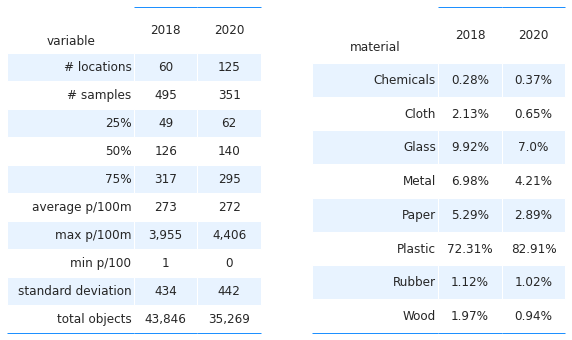

In [6]:
# material totals
mat_total = df.groupby(["survey year", "code"], as_index=False).quantity.sum()

# add material type:
mat_total["mat"] = mat_total.code.map(lambda x:code_material_map.loc[x])

# the cumulative sum of material by category
mat_total = mat_total.groupby(["survey year", "mat"], as_index=False).quantity.sum()

# get the % of total and fail rate for each object from each year
# add the yearly total column
mat_total.loc[mat_total["survey year"] == "2018", "yt"] = mat_total[mat_total["survey year"] == "2018"].quantity.sum()
mat_total.loc[mat_total["survey year"] == "2020", "yt"] = mat_total[mat_total["survey year"] == "2020"].quantity.sum()

# get % of total
mat_total["pt"] =((mat_total.quantity/mat_total.yt)*100).round(2)

# format for printing:
mat_total["pt"] = mat_total.pt.map(lambda x: F"{x}%")
mat_total["quantity"] = mat_total.quantity.map(lambda x: F"{x:,}")

# pivot and rename columns
m_t = mat_total[["survey year","mat", "quantity", "pt"]].pivot(columns="survey year", index="mat", values="pt").reset_index()
m_t.rename(columns={"mat":"material", "pt":"% of total"}, inplace=True)

# put that in a table
fig, axs = plt.subplots(1, 2, figsize=(10,6))

axone = axs[0]
axtwo= axs[1]

# convenience func
sut.hide_spines_ticks_grids(axone)
sut.hide_spines_ticks_grids(axtwo)

# summary data table
a_table = axone.table(cellText=combined_summary.values,  colLabels=combined_summary.columns, colWidths=[.5,.25,.25], loc="lower center", bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary,combined_summary.columns, s_et_bottom_row=True)

# material totals
a_table = axtwo.table(cellText=m_t.values,  colLabels=m_t.columns, colWidths=[.5,.25,.25], loc="lower center", bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,m_t,m_t.columns, s_et_bottom_row=True)

plt.show()

*Chemicals refers to parafin wax and wood refers to treated or wood shaped for use*

#### Difference of medians 2018 - 2020

The observed difference of the medians between the two projects is  14p/100m, differences of this magnitude would not be perceived and may be due to chance. A permutation test was conducted to test the hypothesis:

>*Null hypothesis:* The median survey result from 2018 is not statistically different than the median from 2020. The observed difference is due to chance.

>*Alternate hypothesis:* The median survey result from 2018 is not statistically different than the median from 2020. The observed difference in the samples is not due to chance.

*__Below:__ The distribution of the difference of medians between the two sampling periods. The survey results were shuffled and sampled 5,000 times on the survey year column. The null hypothesis can not be rejected, supporting the argument that the median survey results were approximately equal year over year.*

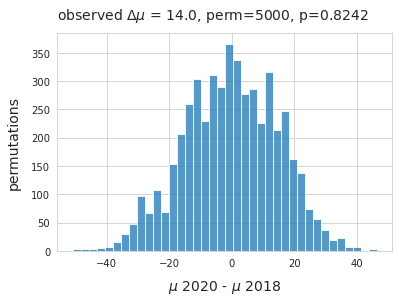

In [7]:
# data for testing
data=df.copy()

# get the survey total for each survey keep the survey year column
pre_shuffle = data.groupby(["loc_date", "survey year"], as_index=False)[unit_label].sum()

# get the median from each year
observed_median = pre_shuffle.groupby("survey year")[unit_label].median()

# get the dif mu_2020 - mu_2017
observed_dif = observed_median.loc["2020"] - observed_median.loc["2018"]

# a place to store the sample statistics
new_medians=[]

# resampling:
for element in np.arange(5000):
    
    # shuffle the entire survey year column
    pre_shuffle["new_class"] = pre_shuffle["survey year"].sample(frac=1, replace=True).values
    # get the median for both "survey years"
    b=pre_shuffle.groupby("new_class").median()
    # get the change and store it    
    new_medians.append((b.loc["2018"] - b.loc["2020"]).values[0])

# calculate the empirical p
emp_p = np.count_nonzero(new_medians <= observed_dif )/ 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_medians, ax=ax)
ax.set_title(F"observed $\u0394\mu$ = {np.round(observed_dif, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel("permutations", **ck.xlab_k14)
ax.set_xlabel("$\mu$ 2020 - $\mu$ 2018", **ck.xlab_k14)
plt.show()


### The most common objects year over year

*__Below:__ The most common objects are the ten most abundant by quantity AND/OR objects identified in at least 50% of all surveys. This accounts for 60% - 80% of all objects identified in any given survey period. The most common objects are not the same year over year. To assess the changes only the objects that were the most common in both years are included. __Left:__ most common objects 2018, __right:__ most common objects 2020*


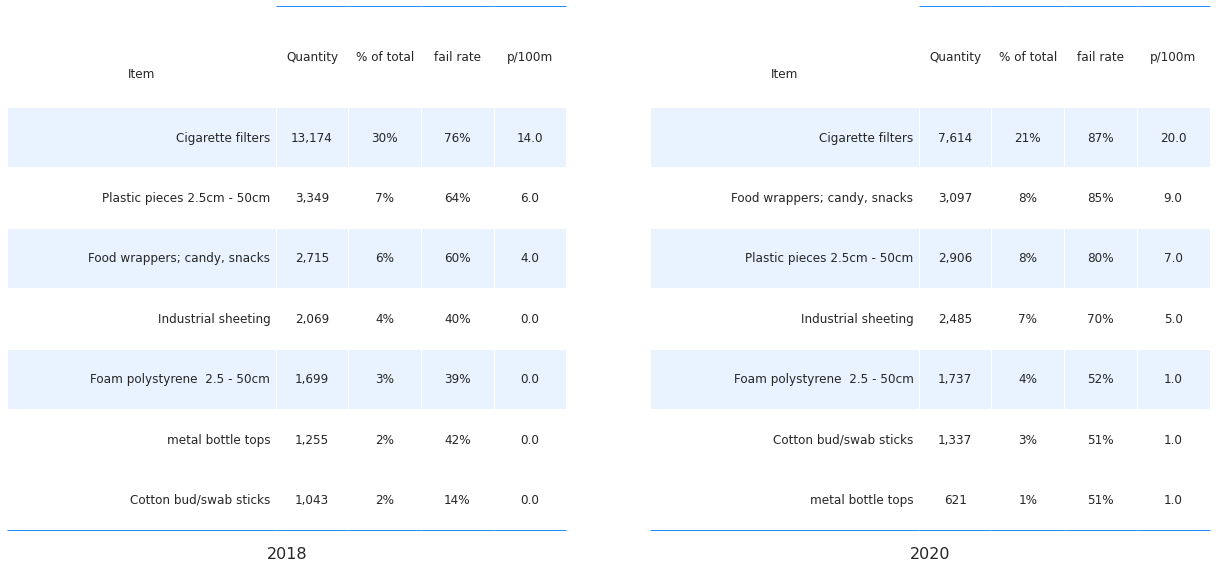

In [8]:
# code totals by project
c_totals = df.groupby(["survey year", "code"], as_index=False).agg({"quantity":"sum", "fail":"sum", unit_label:"median"})

# calculate the fail rate % of total for each code and survey year
for a_year in ["2018", "2020"]:
    c_totals.loc[c_totals["survey year"] == a_year, "fail rate"] = ((c_totals.fail/df[df["survey year"] == a_year].loc_date.nunique())*100).astype("int")
    c_totals.loc[c_totals["survey year"] == a_year, "% of total"] = ((c_totals.quantity/df[df["survey year"] == a_year].quantity.sum())*100).astype("int")
    
# get all the instances where the fail rate is > fail_rate
c_50 = c_totals.loc[c_totals["fail rate"] >= fail_rate]

# the top ten from each project
ten_2017 = c_totals[c_totals["survey year"] == "2018"].sort_values(by="quantity", ascending=False)[:10].code.unique()
ten_2020 = c_totals[c_totals["survey year"] == "2020"].sort_values(by="quantity", ascending=False)[:10].code.unique()

# combine the most common from each year with the top ten from each year
# most common 2017
mcom_2017 = list(set(c_50[c_50["survey year"]=="2018"].code.unique())|set(ten_2017))

# most common 2020
mcom_2020 = list(set(c_50[c_50["survey year"]=="2020"].code.unique())|set(ten_2020))

# the set of objects that were the most common in both years:
mcom = list(set(mcom_2017)&set(mcom_2020))

# get the data
com_2017 = c_totals[(c_totals["survey year"] == "2018")&(c_totals.code.isin(mcom))]
com_2020 = c_totals[(c_totals["survey year"] == "2020")&(c_totals.code.isin(mcom))]

# format values for table
table_data = []
chart_labels = ["2018", "2020"]
for i, som_data in enumerate([com_2017, com_2020]):
    som_data = som_data.set_index("code")
    som_data.sort_values(by="quantity", ascending=False, inplace=True)
    som_data["item"] = som_data.index.map(lambda x: code_description_map.loc[x])
    som_data["% of total"] = som_data["% of total"].map(lambda x: F"{int(x)}%")
    som_data["quantity"] = som_data.quantity.map(lambda x: F"{int(x):,}")
    som_data["fail rate"] = som_data["fail rate"].map(lambda x: F"{int(x)}%")
    som_data[unit_label] = som_data[unit_label].map(lambda x: F"{round(x,2)}")    
    table_data.append({chart_labels[i]:som_data})

# the columns needed
cols_to_use = {"item":"Item","quantity":"Quantity", "% of total":"% of total", "fail rate":"fail rate", unit_label:unit_label}

fig, axs = plt.subplots(1,2, figsize=(17,10*.8))

for i,this_table in enumerate(table_data):
    this_ax = axs[i]
    
    sut.hide_spines_ticks_grids(this_ax)
    the_first_table_data = this_ax.table(table_data[i][chart_labels[i]][cols_to_use.keys()].values,  colLabels=list(cols_to_use.values()), colWidths=[.48, .13,.13,.13, .13], bbox=[0, 0, 1, 1])
    a_summary_table_one = sut.make_a_summary_table(the_first_table_data,table_data[i][chart_labels[i]][cols_to_use.keys()].values,list(cols_to_use.values()), this_palette["2020"])
    this_ax.set_xlabel(chart_labels[i], fontsize=16, labelpad=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.show()

plt.close()

## Results lakes 2018 and 2020
The following lakes were sampled in both project years:

1. Zurichsee
2. Bielersee
3. Neuenburgersee
4. Walensee
5. Lac Léman
6. Thunersee

When considering the six lakes (above), in 2020 there were more samples and locations and greater quantities of litter collected, but the median and average were both lower with respect to 2018. 

In [9]:
# a df with just the lakes of interest
lks_df = df[df.water_name_slug.isin(these_lakes)].copy()

# a month column
lks_df["month"] = lks_df.date.dt.month

# survey totals
lks_dt = lks_df.groupby(["survey year", "water_name_slug","loc_date","date", "month"], as_index=False)[unit_label].sum()

# locations in both years
com_locs_df = lks_df[lks_df.location.isin(both_years)].copy()

# nsamps from locations in both years
nsamps_com_locs = com_locs_df[com_locs_df["survey year"] == "2020"].groupby(["location"], as_index=True).loc_date.nunique()

# common locations surveyed in 2020
com_locs_20 = com_locs_df[com_locs_df["survey year"] == "2020"].location.unique()

# locations surveyed in 2020
locs_lakes = lks_df[lks_df["survey year"] == "2020"].location.unique()

*__Top Left:__ survey totals by date, __Top right:__ median monthly survey total, __bottom Left:__ number of samples with respect to the survey total, __bottom right:__ empirical cumulative distribution of survey totals* 

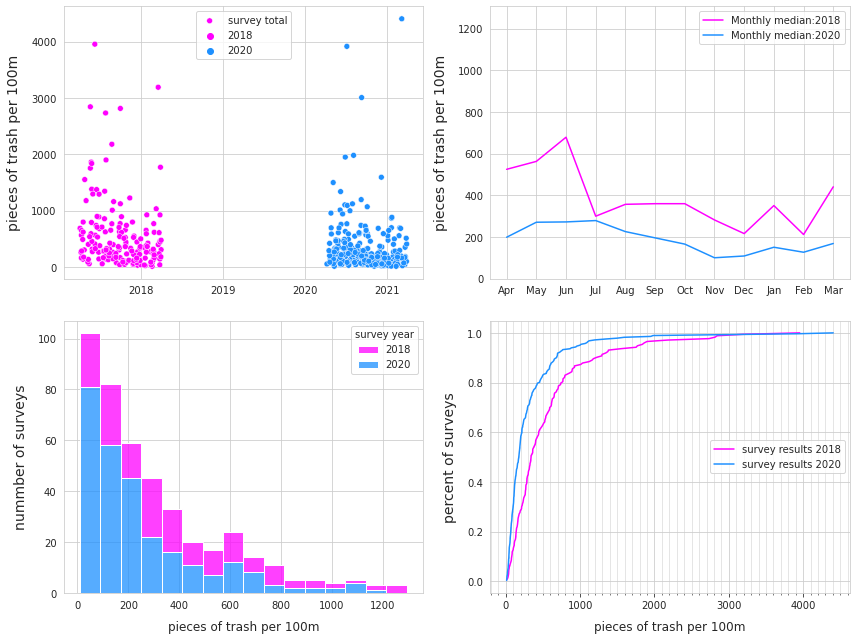

In [10]:
data=lks_df.groupby(["survey year","loc_date", "date"], as_index=False)[unit_label].sum()
data.set_index("date", inplace=True)

# the empirical distributions for each year
ecdf_2017 = ECDF(data[data["survey year"] == "2018"][unit_label].values)
ecdf_2020 = ECDF(data[data["survey year"] == "2020"][unit_label].values)

# get the x,y vals for each year
ecdf_2017_x, ecdf_2017_y = ecdf_2017.x, ecdf_2017.y
ecdf_2020_x, ecdf_2020_y = ecdf_2020.x, ecdf_2020.y

the_90th = np.percentile(data[unit_label], 95)

# the monthly plots
just_2017 = data[data["survey year"] == "2018"][unit_label].resample("M").median()
monthly_2017 = pd.DataFrame(just_2017)
monthly_2017.reset_index(inplace=True)
monthly_2017["month"] = monthly_2017.date.map(lambda x: dt.datetime.strftime(x, "%b"))

just_2020 = data[data["survey year"] == "2020"][unit_label].resample("M").median()
monthly_2020 = pd.DataFrame(just_2020)
monthly_2020.reset_index(inplace=True)
monthly_2020["month"] = monthly_2020.date.map(lambda x: dt.datetime.strftime(x, "%b"))

# long form data for histogram
data_long = pd.melt(data[["survey year", "p/100m"]],id_vars=["survey year"], value_vars=("p/100m",), value_name="survey total")
data_long["year_bin"] = np.where(data_long["survey year"] == "2018", 0, 1)
data_long = data_long[data_long["survey total"] < the_90th].copy()

fig, ax = plt.subplots(2,2, figsize=(12,9), sharey=False)

# set axs and labels
axone=ax[0,0]
axtwo = ax[0,1]
axthree = ax[1,0]
axfour = ax[1,1]

axone.set_ylabel("pieces of trash per 100m", **ck.xlab_k14)
axone.set_xlabel(" ")

axone.xaxis.set_minor_locator(months)
axone.xaxis.set_major_locator(years)

axtwo.set_xlabel(" ")
axtwo.set_ylabel("pieces of trash per 100m", **ck.xlab_k14)

axthree.set_ylabel("nummber of surveys", **ck.xlab_k14)
axthree.set_xlabel("pieces of trash per 100m", **ck.xlab_k)
axtwo.set_ylim(0, the_90th)

axfour.set_ylabel("percent of surveys", **ck.xlab_k14)
axfour.set_xlabel("pieces of trash per 100m", **ck.xlab_k)

# all samples scatter
sns.scatterplot(data=data, x="date", y=unit_label, color="red", s=34, ec="white",label="survey total", hue="survey year", palette= this_palette, ax=axone)

# monthly medians
sns.lineplot(data=monthly_2017, x="month", y=unit_label, color=this_palette["2018"], label=F"Monthly median:2018", ax=axtwo)
sns.lineplot(data=monthly_2020, x="month", y=unit_label, color=this_palette["2020"],label=F"Monthly median:2020",  ax=axtwo)

# histogram of survey results
sns.histplot(data=data_long, x="survey total", hue="survey year", stat="count", multiple="stack", palette=this_palette, ax=axthree)

# ecdfs
sns.lineplot(x=ecdf_2017_x, y=ecdf_2017_y, ax=axfour, color=this_palette["2018"], label="survey results 2018")
sns.lineplot(x=ecdf_2020_x, y=ecdf_2020_y, ax=axfour, color=this_palette["2020"], label="survey results 2020")

axfour.xaxis.set_major_locator(ticker.MultipleLocator(1000)) 
axfour.xaxis.set_minor_locator(ticker.MultipleLocator(100)) 
axfour.legend(loc="center right")
axfour.tick_params(which="both", bottom=True)
axfour.grid(b=True, which="minor",linewidth=0.5)

axone.legend(loc="upper center")

plt.tight_layout()
plt.show()

*__Left:__ summary of survey totals, __right:__ material type*

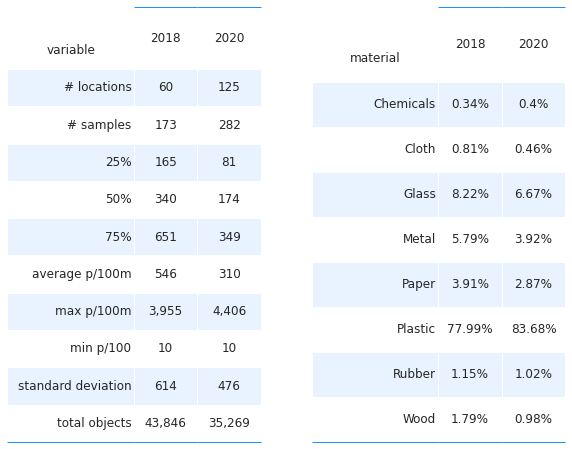

In [11]:
# group by survey year and use pd.describe to get basic stats
som_1720 = lks_dt.groupby("survey year")[unit_label].describe().round(2)

# add total quantity and number of unique locations
som_1720["total objects"] = som_1720.index.map(lambda x: df[df["survey year"] == x].quantity.sum())
som_1720["# locations"] = som_1720.index.map(lambda x: df[df["survey year"] == x].location.nunique())

# make columns names more descriptive
som_1720.rename(columns=(change_names), inplace=True)
ab = som_1720.reset_index()

# melt that on survey year
c_s = ab.melt(id_vars=["survey year"])

# pivot on survey year
combined_summary = c_s.pivot(columns="survey year", index="variable", values="value").reset_index()

# format for printing
combined_summary["2018"] = combined_summary["2018"].map(lambda x: F"{int(x):,}")
combined_summary["2020"] = combined_summary["2020"].map(lambda x: F"{int(x):,}")

# material totals
mat_total = lks_df.groupby(["survey year", "code"], as_index=False).quantity.sum()

# add material type:
mat_total["mat"] = mat_total.code.map(lambda x:code_material_map.loc[x])

# the most common codes for each year
mat_total = mat_total.groupby(["survey year", "mat"], as_index=False).quantity.sum()

# get the % of total and fail rate for each object from each year
# add the yearly total column
mat_total.loc[mat_total["survey year"] == "2018", "yt"] = mat_total[mat_total["survey year"] == "2018"].quantity.sum()
mat_total.loc[mat_total["survey year"] == "2020", "yt"] = mat_total[mat_total["survey year"] == "2020"].quantity.sum()

# get % of total
mat_total["pt"] =((mat_total.quantity/mat_total.yt)*100).round(2)

# format for printing:
mat_total["pt"] = mat_total.pt.map(lambda x: F"{x}%")
mat_total["quantity"] = mat_total.quantity.map(lambda x: F"{x:,}")

m_t = mat_total[["survey year","mat", "quantity", "pt"]].pivot(columns="survey year", index="mat", values="pt").reset_index()
m_t.rename(columns={"mat":"material", "pt":"% of total"}, inplace=True)

# put that in a table
fig, axs = plt.subplots(1, 2, figsize=(10,8))

axone = axs[0]
axtwo= axs[1]

sut.hide_spines_ticks_grids(axone)
sut.hide_spines_ticks_grids(axtwo)

# summary data table
a_table = axone.table(cellText=combined_summary.values,  colLabels=combined_summary.columns, colWidths=[.5,.25,.25], loc="lower center", bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary,combined_summary.columns, s_et_bottom_row=True)

# material totals
a_table = axtwo.table(cellText=m_t.values,  colLabels=m_t.columns, colWidths=[.5,.25,.25], loc="lower center", bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,m_t,m_t.columns, s_et_bottom_row=True)

plt.show()

### Lakes: results most common objects from 2018

*__Below:__ the most common objects were 71% of all objects counted in 2018 versus 60% in 2020. Cigarette filters and fragmented plastic pieces were recorded at almost double the rate in 2018 versus 2020.* 

*Lakes: key indicators of the most common objects 2018 - 2020*

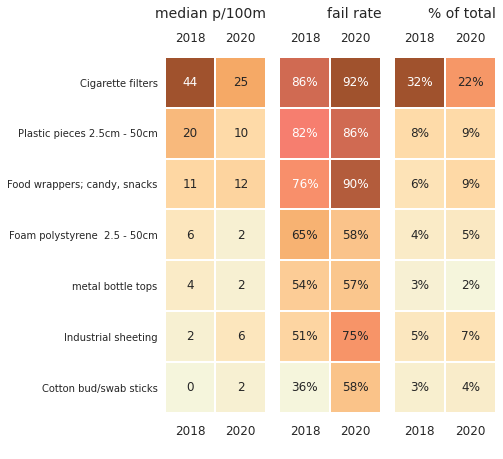

In [12]:
# compare the key indicators of the most common objects
lks_codes = lks_df[lks_df.code.isin(mcom)].copy()
lks_codes = lks_df[lks_df.code.isin(mcom)].groupby(["code", "survey year"], as_index=False).agg({unit_label:"median", "quantity":"sum", "fail":"sum", "loc_date":"nunique"})

# get fail rate and % of total
for a_year in ["2020", "2018"]:
    lks_codes.loc[lks_codes["survey year"] == a_year, "fail rate"] = lks_codes.fail/lks_df[lks_df["survey year"]==a_year].loc_date.nunique()
    lks_codes.loc[lks_codes["survey year"] == a_year, "% of total"] = lks_codes.quantity/lks_df[lks_df["survey year"]==a_year].quantity.sum()

# pivot on the survey year column and keep all the values
pivot_2017_2020 = lks_codes.pivot(columns="survey year", values=[unit_label, "fail rate", "% of total"], index="code")

# map description to code
pivot_2017_2020["Item"] = pivot_2017_2020.index.map(lambda x: code_description_map.loc[x])

# set index and sort
pivot_2017_2020.set_index("Item", inplace=True, drop=True)
pivot_2017_2020.sort_values(by=(unit_label,"2018"), ascending=False, inplace=True)

# plot that
fig = plt.figure(figsize=(8, 12))

# use gridspec to position
spec = GridSpec(ncols=8, nrows=2, figure=fig)
axone = fig.add_subplot(spec[:,1:3])
axtwo = fig.add_subplot(spec[:,3:5])
axthree = fig.add_subplot(spec[:,5:7])

# get an order to assign each ax
an_order = pivot_2017_2020["p/100m"].sort_values(by="2018", ascending=False).index

# index axtwo and and axthree to axone
axtwo_data = pivot_2017_2020["fail rate"].sort_values(by="2018", ascending=False).reindex(an_order)
axthree_data = pivot_2017_2020["% of total"].sort_values(by="2018", ascending=False).reindex(an_order)

# pieces per meter

sns.heatmap(pivot_2017_2020[unit_label], cmap=cmap2, annot=True, fmt=".0f", annot_kws={"fontsize":12},  ax=axone, square=True, cbar=False, linewidth=.05,  linecolor="white")
axone.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axone.set_xlabel(" ")
axone.set_title("median p/100m",**ck.title_k14r)

# fail rate
sns.heatmap(pivot_2017_2020["fail rate"], cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0%", ax=axtwo, square=True,  cbar=False, linewidth=.05,  linecolor="white")
axtwo.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axtwo.tick_params(labelleft=False, left=False)
axtwo.set_xlabel(" ")
axtwo.set_title("fail rate", **ck.title_k14r)

# percent of total
sns.heatmap(pivot_2017_2020["% of total"], cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0%", ax=axthree, square=True,  cbar=False, linewidth=.05,  linecolor="white")
axthree.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axthree.tick_params(labelleft=False, left=False)
axthree.set_xlabel(" ")
axthree.set_title("% of total", **ck.title_k14r)

for anax in [axone, axtwo, axthree]:
    anax.set_ylabel("")

plt.subplots_adjust(wspace=0.3)

plt.show()

### Difference of mean survey total¶ 

When considering only lakes the difference of medians is inversed, less litter was observed in 2020 than 2018 and the difference of means is much larger in favor of 2018. Suggesting that at the lake level there was a decrease in observed quantities. 

> Null hypothesis: The mean of the survey results for lakes from 2018 is not statistically different than the mean for 2020. The observed difference is due to chance. 

> Alternate hypothesis: The mean survey results for lakes in 2018 is not the same in 2020. The observed difference in the samples is significant. 

*__Below:__ The distribution of the difference of means between the two sampling periods. The survey results were shuffled and sampled 5,000 times on the survey year column. The null hypothesis could be rejected, supporting the initial observation that there was less observed in 2020 than 2018.* 

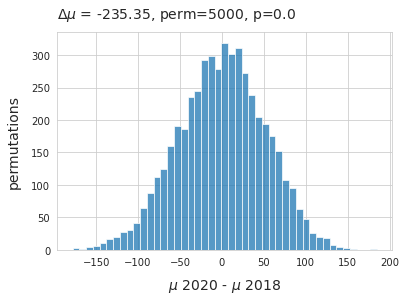

In [13]:
# data for testing
data=df[df.water_name_slug.isin(these_lakes)].copy()

# get the survey total for each survey keep the survey year column
pre_shuffle = data.groupby(["survey year", "loc_date"], as_index=False)[unit_label].sum()

# get the mean for each survey year
observed_mean = pre_shuffle.groupby("survey year")[unit_label].mean()

# get the diff
observed_dif = observed_mean.loc["2020"] - observed_mean.loc["2018"]

new_means=[]
# resampling:
for element in np.arange(5000):
    
    # shuffle the survey year column
    pre_shuffle["new_class"] = pre_shuffle["survey year"].sample(frac=1).values
    # get the means for both years
    b=pre_shuffle.groupby("new_class").mean()
    # get the change and store it
    new_means.append((b.loc["2020"] - b.loc["2018"]).values[0])

# calculate p
emp_p = np.count_nonzero(new_means <= observed_dif )/ 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(observed_dif, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel("permutations", **ck.xlab_k14)
ax.set_xlabel("$\mu$ 2020 - $\mu$ 2018", **ck.xlab_k14)
plt.show()


#### Difference of means most common objects

The observed difference of means between the two sampling periods was -235p/100m. The most common objects are approximately equal to 60% of the total. Changes in the daily total may be reflected in the daily totals of the most common objects as well.

__Test one:__

> Null hypothesis: The mean of the of the survey results of the most common objects from 2018 is the same as 2020. The observed difference is due to chance.

> Alternate hypothesis: The mean of the survey results of the most common objects from 2018 is different than 2020. The observed difference in the samples is significant.

* if p < 0.05 = yellow: the difference is statistically significant.

*__Below:__ The observed difference in means between the two years could be in part explained by the decrease in the quantities of cigarettes, foam polystyrene, metal bottle tops and fragmented plastics.*

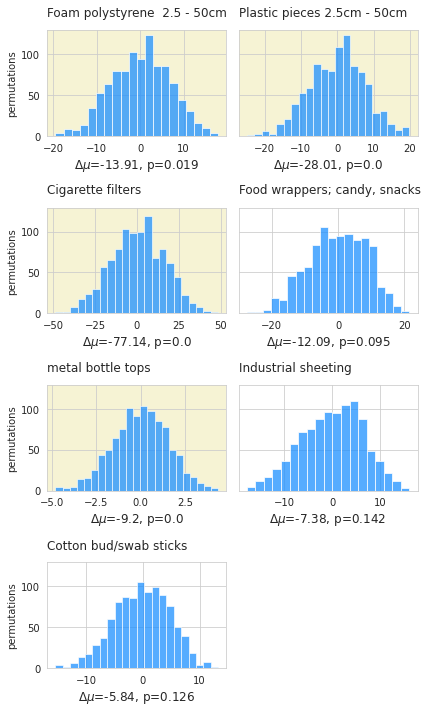

In [14]:
# data testing
data=df[df.water_name_slug.isin(these_lakes)].copy()

# # the common codes from both years
# common_codes_both_years = list(set([*mcom_2017, *mcom_2020]))

# data to resample
pre_shuffle = data[data.code.isin(mcom)].groupby(["survey year", "loc_date", "code"], as_index=False)[unit_label].sum()

# the observed mean from each year
observed_mean = pre_shuffle.groupby(["survey year", "code"])[unit_label].mean()

# get the differences from one year to the next: check the inverse
observed_dif = observed_mean.loc["2020"] - observed_mean.loc["2018"]
inv_diff = observed_mean.loc["2018"] - observed_mean.loc["2020"]

# number of shuffles
perms = 1000

new_means=[]
# resample
for a_code in mcom:
    
    # store the test statisitc
    cdif = []
#     invdif=[]
    
    # code data
    c_data = pre_shuffle[pre_shuffle.code == a_code].copy()
    for element in np.arange(perms):
        # shuffle labels
        c_data["new_class"] = c_data["survey year"].sample(frac=1).values
        b=c_data.groupby("new_class").mean()
        cdif.append((b.loc["2020"] - b.loc["2018"]).values[0])
#         invdif.append((b.loc["2018"] - b.loc["2020"]).values[0])
    
    # calculate p
    emp_p = np.count_nonzero(cdif <= (observed_dif.loc[a_code])) / perms
#     inv_p = np.count_nonzero(invdif >= (observed_dif.loc[a_code])) / perms
    
    # store that result
    new_means.append({a_code:{"p":emp_p,"difs":cdif}})    

# chart the results
fig, axs = plt.subplots(4,2, figsize=(6,10), sharey=True)

for i,code in enumerate(mcom):
    
    # set up the ax
    row = int(np.floor((i/2)%4))
    col =i%2
    ax=axs[row, col]
    
    # data for charts
    data = new_means[i][code]["difs"]
    
    # pvalues
    p=new_means[i][code]["p"]
   
    
    # set the facecolor based on the p value
    
    if p < 0.05:
        ax.patch.set_facecolor("palegoldenrod")
        ax.patch.set_alpha(0.5)        
    # plot that    
    sns.histplot(data, ax=ax, color=this_palette["2020"])
    
    ax.set_title(code_description_map.loc[code], **ck.title_k)
    ax.set_xlabel(F"$\u0394\mu$={np.round(observed_dif.loc[code], 2)}, p={new_means[i][code]['p']}", fontsize=12)
    ax.set_ylabel("permutations")

# hide the unused axs
sut.hide_spines_ticks_grids(axs[3,1])

# get some space for xaxis label
plt.subplots_adjust(hspace=0.25)

plt.tight_layout()
plt.show()

In [15]:
small = lks_df[lks_df.code.isin([ "G20", "G21", "G22", "G23"])].groupby(["code", "survey year"], as_index=False).agg({"quantity":"sum", "p/100m":"median"})
ttl = combined_data.groupby("survey year").quantity.sum()
small.loc[small["survey year"] == "2018", "p_t"] = small.quantity/ttl.loc["2018"]
small.loc[small["survey year"] == "2020", "p_t"] = small.quantity/ttl.loc["2020"]
# print(small.groupby(["survey year","code"]).sum())
# print(small.groupby(["survey year"]).sum())

### Land use profile: Spearmans ranked correlation

The land use features were previously calculated to compare the survey locations. To test the statistical significance of land use on beach litter survey results the survey totals and locations from both projects were considered as one group. The survey results of the most common objects were tested against the measured land use features. 

Spearman"s $\rho$ oor Spearmans ranked correlation coefficient is a non-parametric test of rank correlation between two variables {cite}`defspearmans` {cite}`spearmansexplained`. The test results are evaluated at p<0.05 and 454 samples, SciPy is used to implement the test {cite}`impspearmans`.

1. Red/rose is a positive association: p<0.05 AND $\rho$ > 0
2. yellow is a negative association: p<0.05 AND $\rho$ < 0
3. white medians that p>0.05, there is no statistical basis to assume an association

*__Below:__ An association suggests that survey totals for that object will change in relation to the amount of space attributed to that feature, or in the case of roads or river intersections, the quantity. The magnitude of the relationship is not defined, and any association is not linear.* 

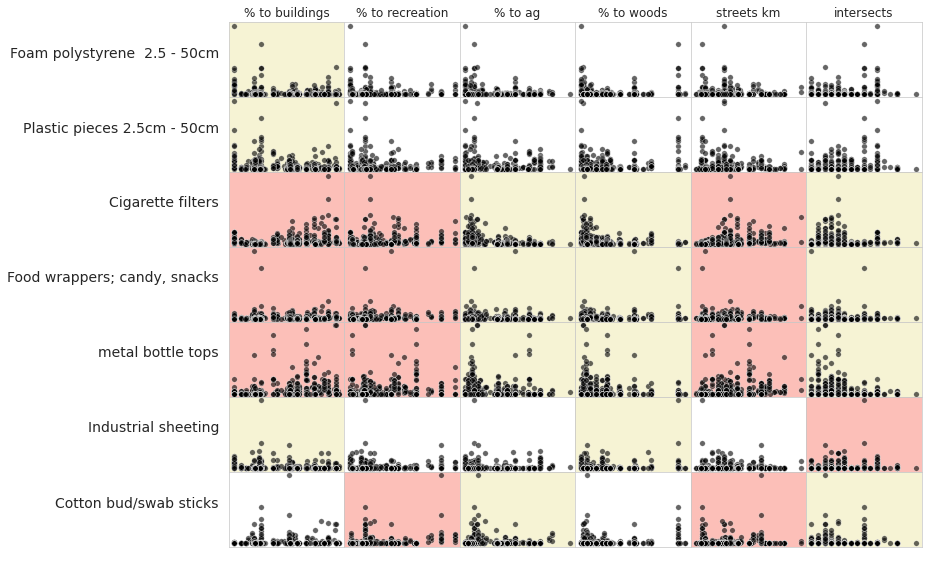

In [16]:
corr_data = lks_df[(lks_df.code.isin(mcom))].copy()

# keys to the column names
some_keys = {
    "% to buildings":"lu_build",
    "% to agg":"lu_agg",
    "% to woods":"lu_woods",
    "% to recreation":"lu_rec",
    "% to trans":"lu_trans",
    "% to meadow":"lu_m",
    "str_rank":"lu_trans"
}

fig, axs = plt.subplots(len(mcom),len(luse_exp), figsize=(len(luse_exp)+7,len(mcom)+1), sharey="row")

for i,code in enumerate(mcom):
    data = corr_data[corr_data.code == code]
    for j, n in enumerate(luse_exp):
        # each grid is its own axis with a scatterplot
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis="both", which="both",bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
       
        if i == 0:
            ax.set_title(F"{n}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha="right", **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        _, corr, a_p = sut.make_plot_with_spearmans(data, ax, n)
        
        # assign the facecolor based on the value of p and rho
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor("salmon")
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor("palegoldenrod")
                ax.patch.set_alpha(0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(F"{project_directory}/test_one.jpg", dpi=300)
plt.show()

#### Interpret Spearmans $\rho$

**Interpreting results for the most common objects** 

A positive association medians that the land use attribute or feature had increased survey results when compared to other locations. This may be due to a covariance of attributes, either way **a positive association is a signal that the survey locations are near a zone of accumulation or a source**. This signal should be assessed along with the other key indicators of survey locations that have similar land use profiles. In general locations that fit the criteria could be considered as both a source and an area of accumulation for any objects that are positively associated.

A negative association medians that the land use feature or attribute does not facilitate the accumulation of the object. This result is common for agricultural areas and woods on the national level. **A negative association is a signal that the locations are not a zone of accumulation for the object**.

No or few association means that the land use features had no effect on the accumulation of that object. The survey results of the most common objects with no or few associations fall into two characteristics: 

1. Ubiquitous: high fail rate, high pieces per meter. Found at consistent rates through out the survey area indifferent of land use
2. Transient: low fail rate, high quantity, high pieces per meter, few associations. Found occasionally in large quantities at specific locations

## Conclusion

### On balance no change

The summary statistics and the results of the difference of medians test imply that there was no statistically measurable change on the national scale from one project to the next. The 95% CI of the median survey total in 2020 was 137 - 188p/100m \( _section [Calculating Baselines](threshhold)_ \). The median result for 2018 was 125p/100m with a CI of 112p/100m to 146p/100m, which includes the lower bound of the median from 2020. __However, the difference of means for the most common objects suggest a more realistic and dynamic result:__

1. There was a statistically significant decrease in four of seven most common objects from both years:
   * cigarette ends
   * metal bottle caps
   * plastic fragments
   * foam fragments
  
The decrease in tobacco and bottle tops is likely the result of pandemic related restrictions that marked 2020. These results suggest that perceived local decreases in litter quantities were most likely the result of a general decline in usage as opposed to a sweeping change in behavior. Consequently the survey results for list 1 items will most likely return to 2018 levels as pandemic related restrictions are relaxed and usage patterns return to _normal_.

The decreases in fragmented foams and plastics is likely due to a difference in protocols between the two years. 

### Protocols matter

There was a key difference between the two projects:

* The 2020 protocol counts all visible objects and classifies fragments by size
* The 2018 protocol limited the object counts to items greater than or equal to 2.5cm in length

The total amount of plastic pieces collected in 2020 is 7,400 or 18p/100m and 5,563 or 5p/100m foamed plastic fragments. There were 3,662 plastic pieces between 0.5cm and 2.5cm removed in 2020, equal to the total amount recorded in 2018. The same for foamed plastics between 0.5cm and 2.5cm, see [_Lakes and rivers_](allsurveys). 

The difference in protocol and the results from 2020 cast doubt on the likelihood of any decrease of fragmented plastics and foamed plastics from 2018 to 2020. Foamed plastics and fragmented plastics are objects whose original use is unknown but the material can be distinguished. Fragmented plastics and foamed plastics greater than 0.5cm are 27% of the total survey results for the lakes in 2020. Studies in the Meuse/Rhine delta show that these small, fragmented objects make up large portions of the total abundance {cite}`meuserhine`.

Allowing surveyors to use a broader range of object codes increases the accuracy of the total survey count and adds levels of differentiation between similar materials. For example, expanded polystyrene is an object that fragments easily. Whether or not surveyors are finding a few larger pieces > 20cm or thousands of pieces < 10mm is an important detail if reducing these objects in the environment is the goal. 

Reduced cost and increased access are another result of a harmonized protocol. The procedures used by the SLR and IQAASL were almost identical, except for the size limit it can be assumed that the samples were collected under similar conditions. The SLR data gives the results of over 1,000 observations by approximately 150 people and the IQAASL data gives the results of 350 observations from approximately 10 people. Both methods have weaknesses and strengths that address very diverse topics: 

* experience of surveyor
* consistency of survey results
* oversight
* intended use of data
* allocation of resources

All of these topics should be considered with each project, as well as stewardship of the data. Regardless of the differences, __we were able to build on the model proposed by the SLR__ and add to the shared experience. 

### Plastic lids

Plastic lids are separated into three categories during the counting process:

1. drink, food 
2. household cleaners etc..
3. unknown

As group plastic lids make up 2% of the total objects in 2018 and 3% in 2020. Drink lids were ~51% of all lids found in 2018, 45% in 2020. On a pieces per meter basis there was a decrease in the amount of drink lids and an increase of non-drink lids from 2018 - 2020. 
   
### Land use profile

The land use profile for each location was calculated using the same data for both years. When survey results from both years are considered as a group the results from Spearmans 𝜌 lend support to the SLR conclusions in 2018 that survey results were elevated in urban and suburban environments and this was also true in 2020. At the same time the ubiquitous nature of fragmented plastics, industrial sheeting and expanded foams noted in [_The land use profile_](luseprofile) was likely prevalent in 2018. 

The amount of land attributed to recreational activities are locations near the survey site designed to accommodate groups of people for various activities. The positive association of tobacco and food/drink related products with this land attribute could be interpreted as the result of temporary increases in population near the survey site. 

### Conclusions

The samples from both projects were taken from locations, in some cases the same location, that had similar levels of infrastructure and economic development. A common protocol was used in both projects, the samples were collected by two different groups and managed by two different associations. 

From 2018 - 2020 there was a statistically significant change, a decrease in the number of objects directly related to behavior at the survey site. This indicates that any perceived decreases were in locations that had a higher % of land attributed to buildings and lower % of land attributed to agriculture or woods. 

Locations with an opposing or different land use profile (less buildings, more agriculture or woods) will most likely not have experienced any decrease at all. For locations near river interchanges or major discharge points there would be no perceivable difference from 2018 - 2020 and increases in fragmented plastics, expanded foams and industrial sheeting were likely. Both the test of difference of medians of the most common objects and the results fromSpearmans $\rho$ oof survey results support this conclusion.

Both survey years show peak survey results in June - July (annex) and lows in November. The possible causes for the peaks and troughs are different depending on the object in question. Food and tobacco objects are more prevalent during the summer season because of increased use. Objects like fragmented plastics depend more on hydrological conditions and the peak discharge rate of the biggest rivers in this study are from May - July(  _section [Shared responsibility](transport)_ ).

Future surveys should include visible items of all sizes. Data aggregation can be done at the server using defined rules based on known relationships. The total count is a key indicator in all statistics that rely on count data, for modeling purposes it is essentia

## Annex

__Pariticipating organizations__

1. Precious plastic leman
2. Association pour la sauvetage du Léman
3. Geneva international School
4. Solid waste management: École polytechnique fédéral Lausanne

### Lakes monthly median common objects: 

All lakes were sampled in all months in both projects. In 2018 the minimum samples per month  was 12 and the maximum was 17 compared to a minimum of 17 and max of 34 in 2020.

*Lakes 2018: monthly average survey result most common objects*

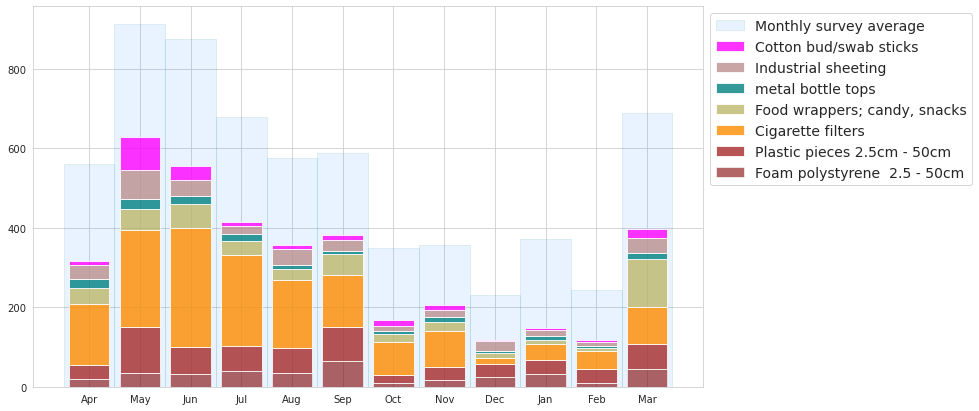

In [17]:
# plot the monthly medidan results for the most common objects
# the code for 2020 is hidden just because it is redundant to see
# slice by survey year
top_ten_month = lks_df[(lks_df["survey year"] == "2018")&(lks_df.code.isin(mcom))].groupby(["loc_date", "date", "code"], as_index=False)[unit_label].sum()
top_ten_month["month"] = top_ten_month.date.dt.month

# copy to work on
dts_date = top_ten_month.copy()
dts_date.set_index("date", inplace=True)

# codes to chart
group_names =  mcom

# a dict to manage all the plots
mgr = {}

# for each of the most common codes resample by month and get the average
for a_group in group_names:
    a_plot = dts_date[(dts_date.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

# some colors for all the codes
colors_palette = {
    "G156":"dimgray",
    "G178": "teal",
    "G177": "darkslategray",
    "G200": "lightseagreen",
    "G27":"darkorange",
    "G30":"darkkhaki",
    "G67":"rosybrown",
    "G89": "salmon",
    "G95":"magenta",
    "G82": "maroon",
    "G79":"brown",
    "G208": "turquoise",
    "G124":"indigo",
    "G25": "chocolate",
    "G31": "goldenrod",
    "G21": "tan",
    "G198":"teal",
    "G204":"plum"
}

# label the axs
months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# plot that
fig, ax = plt.subplots(figsize=(12,7))

def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

# set the bottom of the bar plots
bottom = [0]*len(mgr["G27"])

# average daily total monthly sets the backdrop of the chart
mt = lks_df[lks_df["survey year"] == "2018"].groupby(["loc_date", "date"], as_index=False).agg({unit_label:"sum", "quantity":"sum"})
mt.set_index("date", inplace=True)
monthly_total = mt[unit_label].resample("M").mean().fillna(0)

# chart that
this_x = [i for i,x in  enumerate(monthly_total.index)]
ax.bar(this_x, monthly_total.to_numpy(), color=this_palette["2020"], alpha=0.1, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average")

# for each code lay down a box
for i, a_group in enumerate(group_names):       
    
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 )
    # if i is not zero add to the bottom
    else:
        bottom += mgr[group_names[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# put the handles and labels in the order of the components
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0,"Monthly survey average")

handles = [handles[0], *handles[1:][::-1]]
ax.set_title("")
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

<br></br>
*Lakes 2020: monthly average survey result most common objects*

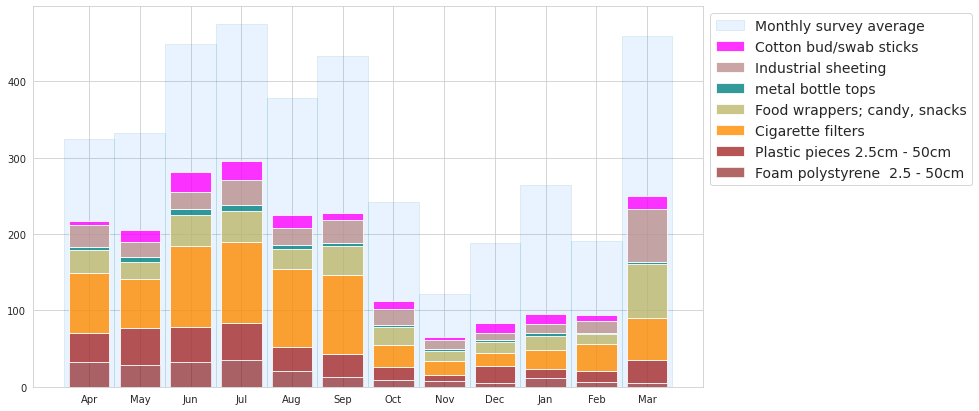

In [18]:
# repeat for 2020
top_ten_month = lks_df[(lks_df["survey year"] == "2020")&(lks_df.code.isin(mcom))].groupby(["loc_date", "date", "code"], as_index=False)["p/100m"].sum()
top_ten_month["month"] = top_ten_month.date.dt.month

dts_date = top_ten_month.copy()
dts_date.set_index("date", inplace=True)

mgr2020 = {}

for a_group in group_names:
    a_plot = dts_date[(dts_date.code==a_group)]["p/100m"].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr2020.update(this_group)
fig, ax = plt.subplots(figsize=(12,7))

bottom = [0]*len(mgr2020["G27"])

mt = lks_df[lks_df["survey year"] == "2020"].groupby(["loc_date", "date"], as_index=False).agg({unit_label:"sum", "quantity":"sum"})
mt.set_index("date", inplace=True)
monthly_total = mt[unit_label].resample("M").mean().fillna(0)

this_x = [i for i,x in  enumerate(monthly_total.index)]
ax.bar(this_x, monthly_total.to_numpy(), color=this_palette["2020"], alpha=0.1, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average")

for i, a_group in enumerate(group_names):       
    
    this_x = [i for i,x in  enumerate(mgr2020[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr2020[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr2020[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6) 
    else:
        bottom += mgr2020[group_names[i-1]].to_numpy()        
        ax.bar(this_x, mgr2020[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()
labelsx = [months[x-1] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0,"Monthly survey average")

handles = [handles[0], *handles[1:][::-1]]
ax.set_title("", **ck.title_k14)
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

<a id="gps"></a>
#### [Survey locations](#annex)

In [19]:
# display the survey locations
pd.set_option("display.max_rows", None)
disp_columns = ["latitude", "longitude", "water_name", "city", "is_2020"]
disp_beaches = dfBeaches.loc[lks_df.location.unique()][disp_columns].sort_values(by="is_2020")
disp_beaches

,latitude,longitude,water_name,city,is_2020
slug,,,,,
zurichsee-feldeggstr-banningersand,47.359392,8.547368,Zurichsee,Zürich,False
la-morges,46.504063,6.494099,Lac Léman,Morges,False
lac-leman-hammerdirt,46.450389,6.858234,Lac Léman,La Tour-de-Peilz,False
lacleman_gland_kubela,46.402869,6.281936,Lac Léman,Gland,False
zuerichsee_zurich_kullg,47.353957,8.550474,Zurichsee,Zürich,False
neuenburgersee_cudrefin_mattera,46.962709,7.025968,Neuenburgersee,Cudrefin,False
lacleman_vidy_santie,46.518318,6.589608,Lac Léman,Lausanne,False
zuerichsee_maennedorf_vanderkaadene,47.254754,8.687504,Zurichsee,Männedorf,False
plage-de-st-sulpice,46.513265,6.570977,Lac Léman,Saint-Sulpice (VD),True
